In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
pal = sns.color_palette()
mac_path = '/Users/jingweizhang/Dropbox/DataScience/Kaggle/BenzGreenerManufacturing'
print('# File Sizes')
for f in os.listdir(mac_path):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize(mac_path + '/' + f) / \
                                      1000000, 2)) + 'MB')

# File Sizes
BenzGreenManufacturing_feature1.ipynb0.93MB
test.csv                      3.19MB
train.csv                     3.22MB
.ipynb_checkpoints            0.0MB
BenzGreenManufacturing_xgboost1.ipynb0.0MB
sample_submission.csv         0.09MB


## train set

In [4]:
df_train = pd.read_csv(mac_path + '/' + 'train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


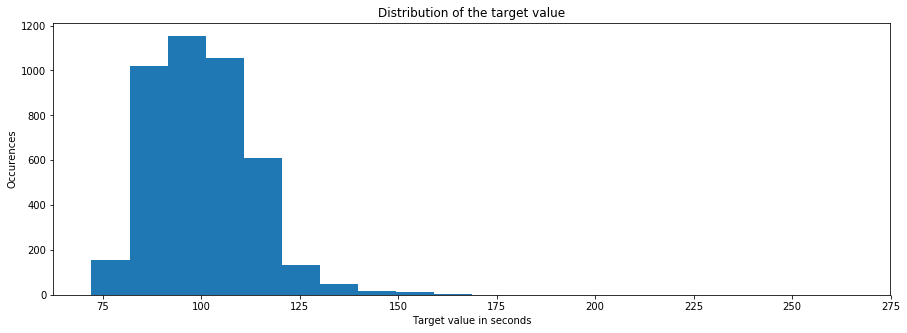

In [5]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 180)))

So we have a pretty standard distribution here, which is centred around almost exactly 100. Nothing special to note here, except there is a single outlier at 265 seconds where every other value is below 180.

The fact that our ID is not equal to the row ID seems to suggest that the train and test sets were randomly sampled from the same dataset, which could have some special order to it, for example a time series. Let's take a look at how this target value changes over time in order to understand whether we're given time series data.

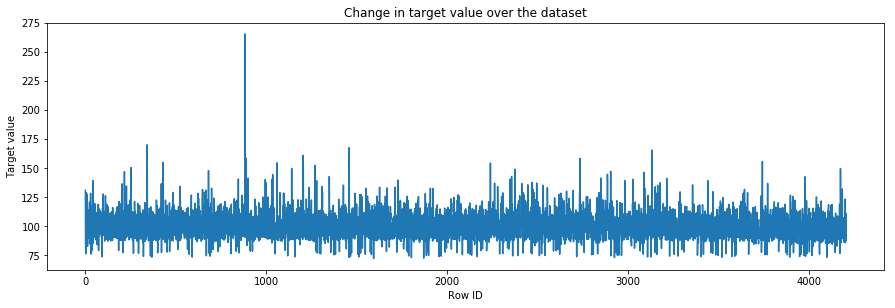

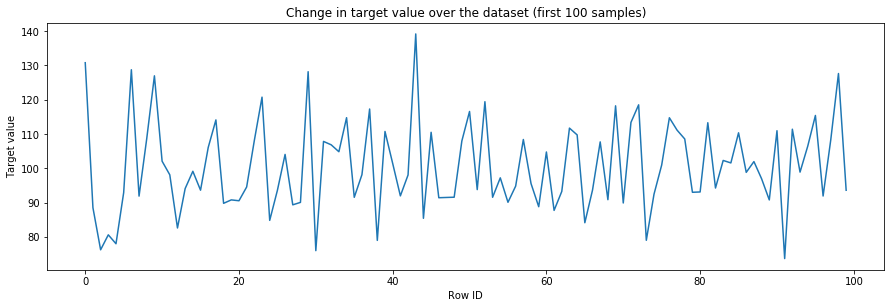

In [7]:
plt.figure(figsize=(15, 10))
plt.subplot(211)
plt.plot(y_train)
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset')
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(212)
plt.plot(y_train[:100])
plt.xlabel('Row ID')
plt.ylabel('Target value')
plt.title('Change in target value over the dataset (first 100 samples)')
plt.show()

## Feature analysis

In [8]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

In [10]:
counts = [[], [], []]
for c in cols:
    typ = df_train[c].dtype
    uniq = len(np.unique(df_train[c]))
    if uniq == 1:
        counts[0].append(c)
    elif (uniq == 2 and typ == np.int64):
        counts[1].append(c)
    else:
        counts[2].append(c)
        
print('Constant features: {} Binary features: {} Categorical features: {}\n'\
      .format(*[len(c) for c in counts]))

print('Constant features:', counts[0])
print('Categorical features:', counts[2])

Constant features: 12 Binary features: 356 Categorical features: 8

Constant features: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Categorical features: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']


Interestingly, we have 12 features which only have a single value in them - these are pretty useless for supervised algorithms, and should probably be dropped (unless you want to use them for anomaly detection in case a different value appears in the test set)

The rest of our dataset is made up of many binary features, and a few categorical features.

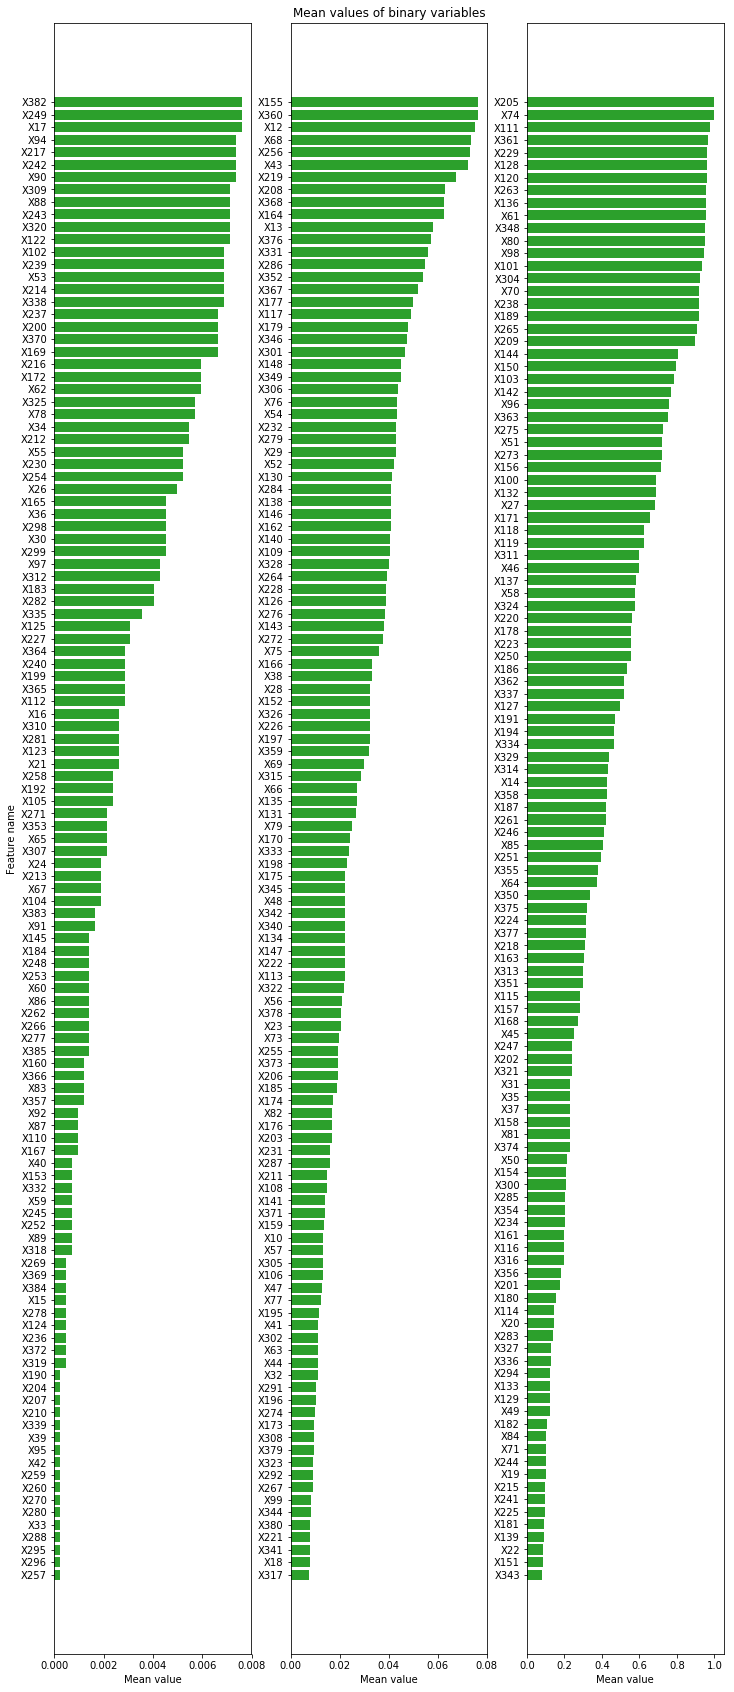

In [21]:
binary_means = [np.mean(df_train[c]) for c in counts[1]]
# print(binary_means)
binary_names = np.array(counts[1])[np.argsort(binary_means)]
# print(binary_names)
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1, 3, figsize=(12, 30))
ax[0].set_ylabel('Feature name')
ax[1].set_title('Mean values of binary variables')

for i in range(3):
    names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
    ax[i].barh(range(len(means)), means, color=pal[2])
    ax[i].set_xlabel('Mean value')
    ax[i].set_yticks(range(len(means)))
    ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()

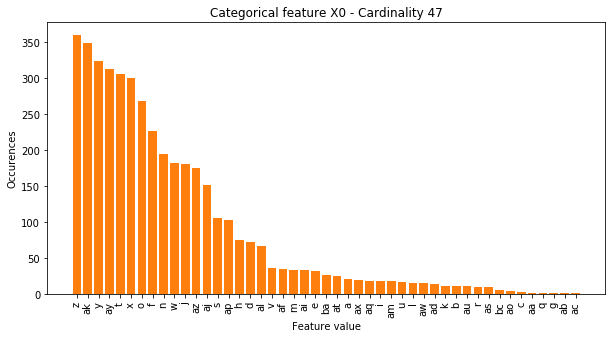

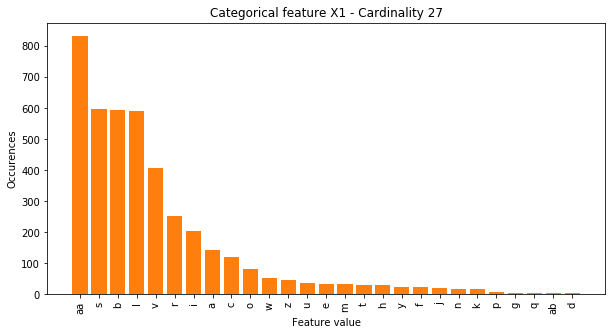

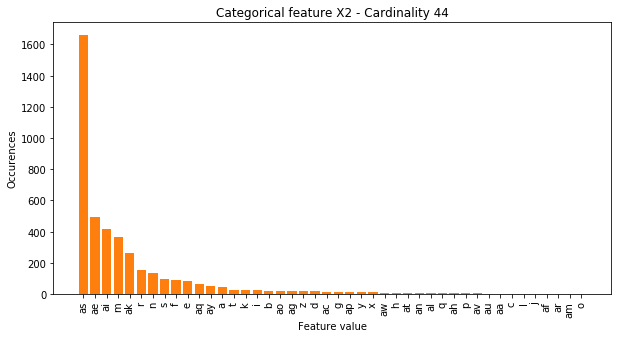

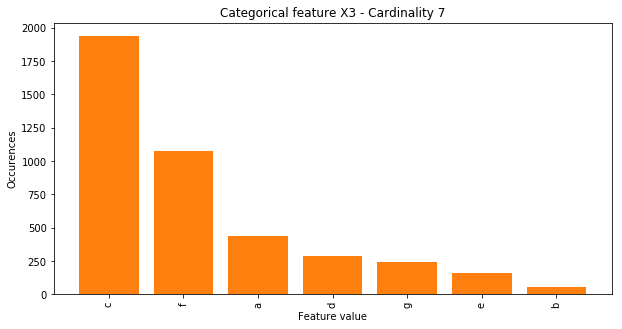

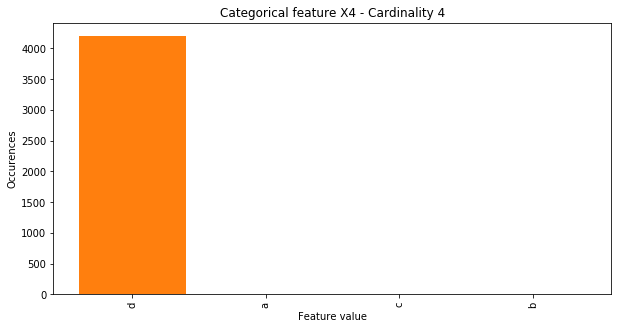

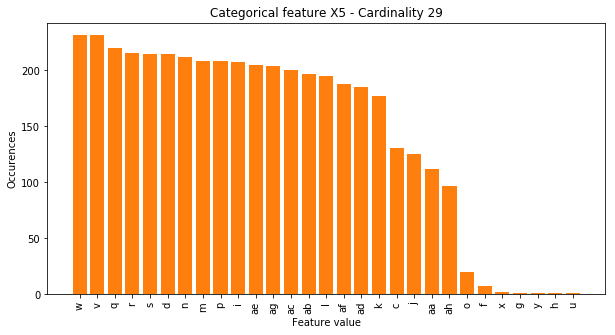

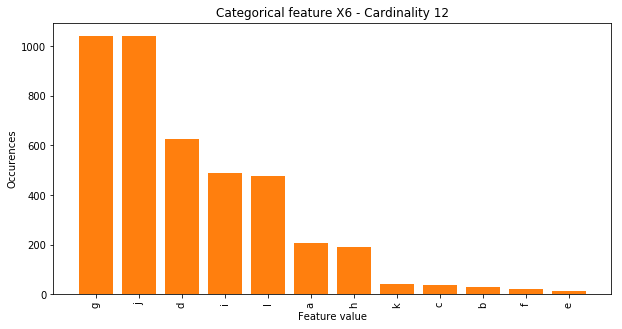

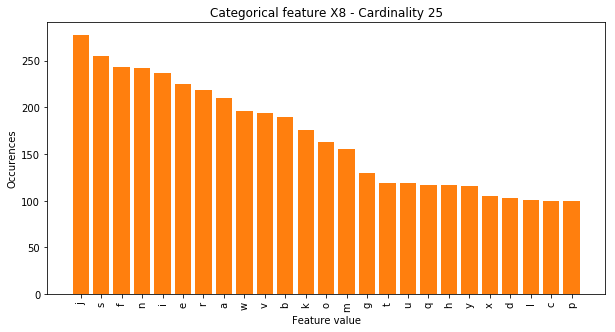

In [22]:
for c in counts[2]:
    value_counts = df_train[c].value_counts()
    fig, ax = plt.subplots(figsize = (10, 5))
    plt.title('Categorical feature {} - Cardinality {}'.format\
              (c, len(np.unique(df_train[c]))))
    plt.xlabel('Feature value')
    plt.ylabel('Occurences')
    plt.bar(range(len(value_counts)), value_counts.values, color=pal[1])
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation='vertical')
    plt.show()

## XGBoost Starter
Now that we know the outline of what the data's made up of, we can make a simple model on it. Time to bring out XGBoost!

In [26]:
df_test = pd.read_csv(mac_path + '/' + 'test.csv')

usable_columns = list(set(df_train.columns) - set(['ID', 'y']))

y_train = df_train['y'].values
id_test = df_test['ID'].values

x_train = df_train.drop(['ID', 'y'], axis=1)
x_test = df_test.drop(['ID'], axis=1)

for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1, inplace=True)
        x_test.drop(column, axis=1, inplace=True)
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        x_test[column] = x_test[column].apply(mapper)
x_train.head() 

,X0,X1,X2,X3,X4,X5,X6,X8,X10,X12,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,107,118,213,97,100,117,106,111,0,0,...,0,0,1,0,0,0,0,0,0,0
1,107,116,215,101,100,121,108,111,0,0,...,1,0,0,0,0,0,0,0,0,0
2,219,119,110,99,100,120,106,120,0,0,...,0,0,0,0,0,0,1,0,0,0
3,219,116,110,102,100,120,108,101,0,0,...,0,0,0,0,0,0,0,0,0,0
4,219,118,110,102,100,104,100,110,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, \
                                                      test_size=0.2, random_state=4242)
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(x_test)

params = {}
params['objective'] = 'reg:linear'
params['eta'] = 0.02
params['max_depth'] = 4

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, \
                feval=xgb_r2_score, maximize=True, verbose_eval=10)


[0]	train-rmse:99.1397	valid-rmse:98.2538	train-r2:-58.3426	valid-r2:-67.6247
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 50 rounds.
[10]	train-rmse:81.1832	valid-rmse:80.2714	train-r2:-38.7928	valid-r2:-44.804
[20]	train-rmse:66.541	valid-rmse:65.5967	train-r2:-25.7332	valid-r2:-29.5876
[30]	train-rmse:54.6149	valid-rmse:53.6305	train-r2:-17.0092	valid-r2:-19.4459
[40]	train-rmse:44.9172	valid-rmse:43.8842	train-r2:-11.1814	valid-r2:-12.6899
[50]	train-rmse:37.0508	valid-rmse:35.9587	train-r2:-7.28831	valid-r2:-8.19158
[60]	train-rmse:30.6913	valid-rmse:29.5289	train-r2:-4.68723	valid-r2:-5.19837
[70]	train-rmse:25.5745	valid-rmse:24.3342	train-r2:-2.949	valid-r2:-3.20936
[80]	train-rmse:21.4844	valid-rmse:20.1622	train-r2:-1.78687	valid-r2:-1.88973
[90]	train-rmse:18.2427	valid-rmse:16.8438	train-r2:-1.00933	valid-r2:-1.01679
[100]	train-rmse:15.7022	valid-rmse:14.2284	train-r2:-0.488656	valid-r2:-0

In [28]:
p_test = clf.predict(d_test)

sub = pd.DataFrame()
sub['ID'] = id_test
sub['y'] = p_test
sub.to_csv('xgb.csv', index=False)

In [29]:
sub.head()

,ID,y
0,1,89.319649
1,2,104.898849
2,3,89.684471
3,4,77.551781
4,5,111.189957
